* Labels: All
* Size: (28,28)
* Data augmentation: YES (without generators and chances for caracteristics)
* Model Layers: 2 conv2D (64,64), 2 dense layers and relu in all layers
* Testing implemented
* New Dataset

### Defining Dataset Path

In [1]:
import os
dataset_directory = 'D:\\.Dataset05032024 - TCC\\labels'
os.makedirs(dataset_directory, exist_ok=True)
os.chdir(dataset_directory)

### Loading Data into train, validation and teste folders

In [2]:
from shutil import copyfile
from sklearn.model_selection import train_test_split

In [12]:
train_directory = 'D:\\.Dataset05032024 - TCC\\result\\train'
validation_directory = 'D:\\.Dataset05032024 - TCC\\result\\validate'
test_directory = 'D:\\.Dataset05032024 - TCC\\result\\test'

In [4]:
def load_data_into_train_validation_test(dataset_directory, train_directory, validation_directory, test_directory):
    
    # Lista de pastas de classe (uma pasta para cada classe de roupa)
    class_folders = os.listdir(dataset_directory)
    
    # Porcentagem de imagens para validação e teste (10% para cada)
    validation_percent = 0.17
    test_percent = 0.14
    
    # Loop através de cada pasta de classe
    for class_folder in class_folders:
    
        # Diretório completo da pasta de classe original
        class_folder_path = os.path.join(dataset_directory, class_folder)
    
        # Lista de todas as imagens na pasta de classe
        images = os.listdir(class_folder_path)
    
        # Calcule o número de imagens a serem movidas para validação e teste
        validation_images_quantity = int(len(images) * validation_percent)
        test_images_quantity = int(len(images) * test_percent)
    
        # Divida as imagens em treinamento, validação e teste
        train_images = images[validation_images_quantity + test_images_quantity:]
        validation_images = images[:validation_images_quantity]
        test_images = images[validation_images_quantity:validation_images_quantity + test_images_quantity]
        # print("train_images", train_images)
    
        # Crie diretórios para treinamento, validação e teste para a classe atual
        train_class_directory = os.path.join(train_directory, class_folder)
        validation_class_directory = os.path.join(validation_directory, class_folder)
        test_class_directory = os.path.join(test_directory, class_folder)
    
        # print("train_class_directory", train_class_directory)
        # print("validation_class_directory", validation_class_directory)
        # print("test_class_directory", test_class_directory)

        os.makedirs(train_class_directory, exist_ok=True)
        os.makedirs(validation_class_directory, exist_ok=True)
        os.makedirs(test_class_directory, exist_ok=True)

        # Mova as imagens para os diretórios correspondentes
        for image in train_images:
            # print("image", image)
            src = os.path.join(class_folder_path, image)
            # print("scr", src)
            dst = os.path.join(train_class_directory, image)
            # print("dst", dst)
            copyfile(src, dst)
    
        for image in validation_images:
            src = os.path.join(class_folder_path, image)
            dst = os.path.join(validation_class_directory, image)
            copyfile(src, dst)
    
        for image in test_images:
            src = os.path.join(class_folder_path, image)
            dst = os.path.join(test_class_directory, image)
            copyfile(src, dst)

In [5]:
load_data_into_train_validation_test(dataset_directory, train_directory, validation_directory, test_directory)

### Defining Pre Processing (Redefinition and Normalization)

In [6]:
target_size = (28, 28) # Tamanho alvo para redimensionamento

def preprocess_image(image_path):
    
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array /= 255.0  # Normalização dos valores dos pixels para [0, 1]
    
    return img_array

### Saving images with pre-processing definitions

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [8]:
dataset_directories = [train_directory, validation_directory, test_directory]

In [9]:
def saving_images_with_preprocessig_definitions(dataset_directories):

    for dataset_directory in dataset_directories:
    
        # Loop através de cada pasta de classe em treinamento
        for class_folder in os.listdir(dataset_directory):
    
            # Crie uma figura com três subplots em uma linha
            if (dataset_directory == train_directory): fig, axs = plt.subplots(1, 3, figsize=(6, 2))
    
            class_folder_path = os.path.join(dataset_directory, class_folder)
    
            i = 0
            # Loop através de cada imagem na pasta de classe
            for image_name in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, image_name)
    
                # Pré-processar a imagem
                preprocessed_image = preprocess_image(image_path)
    
                # Salvar a imagem pré-processada de volta ao mesmo local
                array_img = array_to_img(preprocessed_image)
                array_img.save(image_path)
    
                if (dataset_directory == train_directory and i < 3):
                    axs[i].imshow(preprocessed_image)
                    axs[i].axis('off')
                    i += 1
            
    plt.show()

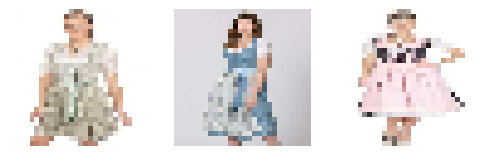

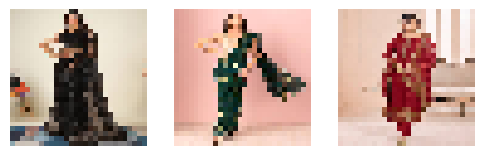

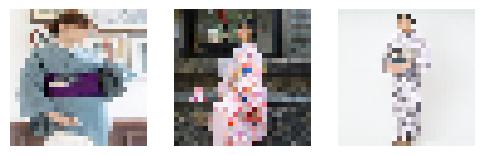

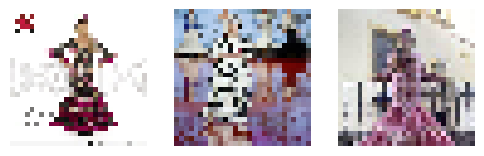

In [10]:
saving_images_with_preprocessig_definitions(dataset_directories)

### Including Augmented Images on Train Directory

In [11]:
import imgaug as ia
from imgaug import augmenters as iaa

In [12]:
rotation_range = 10
width_shift_range = 0.1
height_shift_range = 0.1
shear_range = 0.1
zoom_range = 0.1
horizontal_flip = True

In [13]:
generating_augmented_images = iaa.Sequential([
    # Virar Horizontalmente
    iaa.Fliplr(p=0.5),
    # Rotação Aleatória
    iaa.Sometimes(0.4, iaa.Affine(rotate=(-rotation_range, rotation_range))),
    # Deslocamento Horizontal e Vertical
    iaa.Sometimes(0.3, iaa.Affine(translate_percent={"x": (-width_shift_range, width_shift_range),
                                                     "y": (-height_shift_range, height_shift_range)})),
    # Zoom Aleatório
    iaa.Sometimes(0.2, iaa.Affine(scale=(1 - zoom_range, 1 + zoom_range))),
    # Sem probabilidade, sempre aplicada
    iaa.Affine(shear=(-shear_range, shear_range)),
], random_order=True)  # Aplica as augmentations em ordem aleatória


In [14]:
from tensorflow.keras.utils import save_img

In [15]:
def including_augmented_images(train_directory):
    
    for class_folder in os.listdir(train_directory):
    
        class_folder_path = os.path.join(train_directory, class_folder)
        images = os.listdir(class_folder_path)
    
        fig, axs = plt.subplots(1, 3, figsize=(6, 2))
    
        for i, image_name in enumerate(images):
            image_path = os.path.join(class_folder_path, image_name)
    
            img = load_img(image_path, target_size=target_size)
            img_array = img_to_array(img)
    
            # Crie uma lista que contenha a mesma imagem original três vezes
            image_list = [img_array, img_array, img_array]
    
            # Aplicar augmentations à lista de imagens
            augmented_images = generating_augmented_images(images=image_list)
    
            k = 0
            # Salvar as imagens aumentadas no mesmo diretório
            for j, augmented_image in enumerate(augmented_images):
    
                image_name, image_extension = os.path.splitext(image_path)
                new_image_path = f"{image_name}aug_{j+1}_{total_images_generated}{image_extension}"
    
                # Converta a imagem aumentada em um formato válido
                augmented_image = np.uint8(augmented_image)
                save_img(new_image_path, augmented_image)
    
                axs[k].imshow(augmented_image)
                axs[k].axis('off')
                k += 1
    
        plt.show()

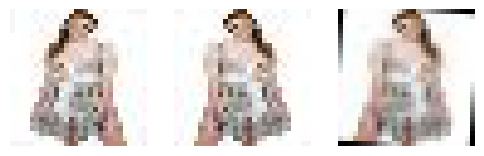

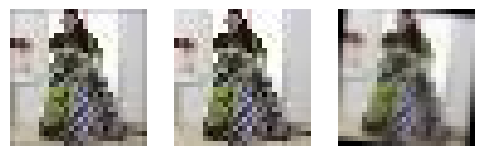

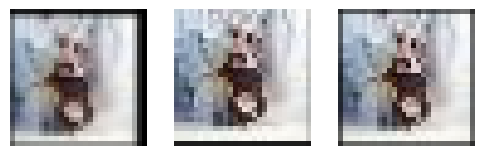

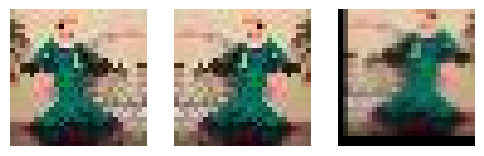

In [16]:
total_images_generated = 3
including_augmented_images(train_directory)

In [17]:
### Defining this Dataset Model variables from train, validation and test folders

In [14]:
batch_size = 3
target_size = (28, 28)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    image_size=(target_size),
    batch_size=batch_size
)

# print(train_dataset)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    image_size=(target_size),
    batch_size=batch_size
)

# print(validation_dataset)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    image_size=(target_size),
    batch_size=batch_size
)

# print(test_dataset)

Found 16244 files belonging to 4 classes.
Found 997 files belonging to 4 classes.
Found 821 files belonging to 4 classes.


### Creating Model

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, PReLU, MaxPooling2D, Flatten, Dense, Dropout

In [3]:
import tensorflow as tf

model = tf.keras.Sequential([

    BatchNormalization(input_shape=(28, 28, 3)),

    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.1),

    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),

    Dense(4, activation="softmax")
])

In [4]:
model.build(input_shape=(None, 28, 28, 3))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 28, 28, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0

### Compiling Model

In [6]:
from tensorflow.keras.optimizers import Adam

In [7]:
adam = Adam(learning_rate=0.001)

In [8]:
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Training Model

###### Defining Callback Methods:

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

*   Checkpoint to save best model weights


In [10]:
checkpoint_path = 'model_checkpoint'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

*   Earlystop to stop the training process when the model stops improving



In [ ]:
early_stopping = EarlyStopping(monitor='accuracy', patience=10)

*   TensorBoard to use logs for vizualize whats happening



In [ ]:
!pip install ngrok

   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
    --------------------------------------- 0.1/3.2 MB 1.1 MB/s eta 0:00:03
   - -------------------------------------- 0.1/3.2 MB 1.2 MB/s eta 0:00:03
   -- ------------------------------------- 0.2/3.2 MB 1.3 MB/s eta 0:00:03
   --- ------------------------------------ 0.3/3.2 MB 1.4 MB/s eta 0:00:03
   ---- ----------------------------------- 0.3/3.2 MB 1.4 MB/s eta 0:00:03
   ----- ---------------------------------- 0.4/3.2 MB 1.5 MB/s eta 0:00:02
   ------ --------------------------------- 0.5/3.2 MB 1.4 MB/s eta 0:00:02
   ------ --------------------------------- 0.5/3.2 MB 1.4 MB/s eta 0:00:02
   ------- -------------------------------- 0.6/3.2 MB 1.5 MB/s eta 0:00:02
   -------- ------------------------------- 0.7/3.2 MB 1.5 MB/s eta 0:00:02
   --------- ------------------------------ 0.7/3.2 MB 1.5 MB/s eta 0:00:02
   ---------- ----------------------------- 0.8/3.2 MB 1.4 MB/s eta 0:00:02
   ----------- ----

In [ ]:
from tensorboard import notebook
import ngrok

In [ ]:
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

In [ ]:
# Iniciar o TensorBoard em segundo plano
os.system("tensorboard --logdir ./logs --host 0.0.0.0 --port 6006 &")

In [ ]:
# Abrir um túnel para o TensorBoard
public_url = ngrok.connect(6006, "http")
print("TensorBoard disponível em:", public_url)

*   Visualizar as ativações de camadas intermediárias durante o treinamento para entender como as características são extraídas e transformadas em diferentes estágios do modelo.



In [ ]:
# class ActivationLogger(tf.keras.callbacks.Callback):
#     def __init__(self, layers):
#         self.layers = layers
#         self.activations = []

#     def on_epoch_end(self, epoch, logs=None):
#         layer_outputs = [layer.output for layer in self.model.layers if layer.name in self.layers]
#         activation_model = tf.keras.models.Model(inputs=self.model.input, outputs=layer_outputs)
#         activations = activation_model.predict(test_dataset)  # Use test_dataset ou outro conjunto relevante
#         self.activations.append(activations)

In [ ]:
# # Nomes das camadas cujas ativações você deseja visualizar
# activation_layers = ['conv2d', 'dense_1']

# activation_logger = ActivationLogger(activation_layers)

###### Starting training with defined callbacks

In [15]:
history = model.fit(
    train_dataset,                          # Conjunto de dados de treinamento
    epochs=10000,                             # Número de épocas de treinamento
    validation_data=validation_dataset,     # Conjunto de dados de validação (separado anteriormente)
    callbacks=[checkpoint], # Callback para salvar os melhores pesos #, early_stopping, tensorboard_callback, activation_logger
    verbose=2                               # Exibir informações de treinamento
)

Epoch 1/10000



Epoch 1: val_accuracy improved from -inf to 0.52758, saving model to model_checkpoint


INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


5415/5415 - 223s - loss: 1.3157 - accuracy: 0.3883 - val_loss: 1.0337 - val_accuracy: 0.5276 - 223s/epoch - 41ms/step
Epoch 2/10000

Epoch 2: val_accuracy improved from 0.52758 to 0.65296, saving model to model_checkpoint


INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


5415/5415 - 72s - loss: 1.2204 - accuracy: 0.4475 - val_loss: 0.9171 - val_accuracy: 0.6530 - 72s/epoch - 13ms/step
Epoch 3/10000

Epoch 3: val_accuracy improved from 0.65296 to 0.69007, saving model to model_checkpoint


INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


5415/5415 - 73s - loss: 1.1314 - accuracy: 0.5082 - val_loss: 0.8279 - val_accuracy: 0.6901 - 73s/epoch - 13ms/step
Epoch 4/10000

Epoch 4: val_accuracy improved from 0.69007 to 0.73220, saving model to model_checkpoint


INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


5415/5415 - 74s - loss: 1.1115 - accuracy: 0.5318 - val_loss: 0.7274 - val_accuracy: 0.7322 - 74s/epoch - 14ms/step
Epoch 5/10000

Epoch 5: val_accuracy improved from 0.73220 to 0.78134, saving model to model_checkpoint


INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


5415/5415 - 72s - loss: 1.0175 - accuracy: 0.5850 - val_loss: 0.5944 - val_accuracy: 0.7813 - 72s/epoch - 13ms/step
Epoch 6/10000

Epoch 6: val_accuracy did not improve from 0.78134
5415/5415 - 66s - loss: 0.9903 - accuracy: 0.5985 - val_loss: 0.6026 - val_accuracy: 0.7763 - 66s/epoch - 12ms/step
Epoch 7/10000

Epoch 7: val_accuracy improved from 0.78134 to 0.81846, saving model to model_checkpoint


INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


5415/5415 - 72s - loss: 0.8924 - accuracy: 0.6557 - val_loss: 0.5105 - val_accuracy: 0.8185 - 72s/epoch - 13ms/step
Epoch 8/10000

Epoch 8: val_accuracy improved from 0.81846 to 0.85256, saving model to model_checkpoint


INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


5415/5415 - 1336s - loss: 0.8640 - accuracy: 0.6713 - val_loss: 0.4598 - val_accuracy: 0.8526 - 1336s/epoch - 247ms/step
Epoch 9/10000


: 

### Evaluating Model

###### Evaluating Model by Loss and Accuracy with the Test Data

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

print(f'Teste - Perda: {test_loss}, Acurácia: {test_accuracy}')

Teste - Perda: 0.40933558344841003, Acurácia: 0.886723518371582


###### Plot Graphs to vizualise loss and accuracy through the epochs

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='purple', label='val_accuracy')
plt.title('Curva de Precisão')
plt.xlabel('Época')
plt.ylabel('Precisão')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='purple', label='val_loss')
plt.title('Curva de Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.show()

: 

###### Plot Confusion Matrix

A matriz de confusão é uma tabela que mostra as contagens de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos. É especialmente útil em problemas de classificação com várias classes.


16/16 [==============================] - 0s 10ms/step


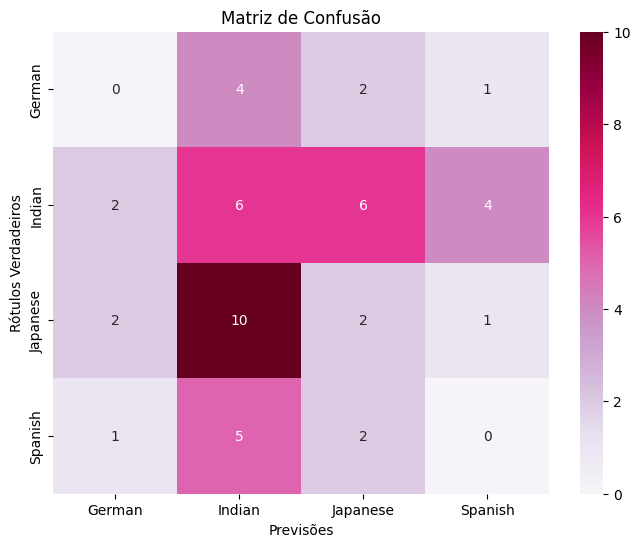

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obter previsões do conjunto de teste
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)  # Use argmax para obter a classe prevista

# Obter rótulos verdadeiros do conjunto de teste
true_labels = [label for _, label in test_dataset.unbatch()]

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Definir rótulos das classes
class_labels = ["German", "Indian", "Japanese", "Spanish"]

# Visualizar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="PuRd", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Previsões")
plt.ylabel("Rótulos Verdadeiros")
plt.title("Matriz de Confusão")
plt.show()

###### Plot Heatmap Error

Criar heatmaps que destacam onde o modelo está cometendo erros pode ajudar a identificar padrões específicos que podem ser melhorados.

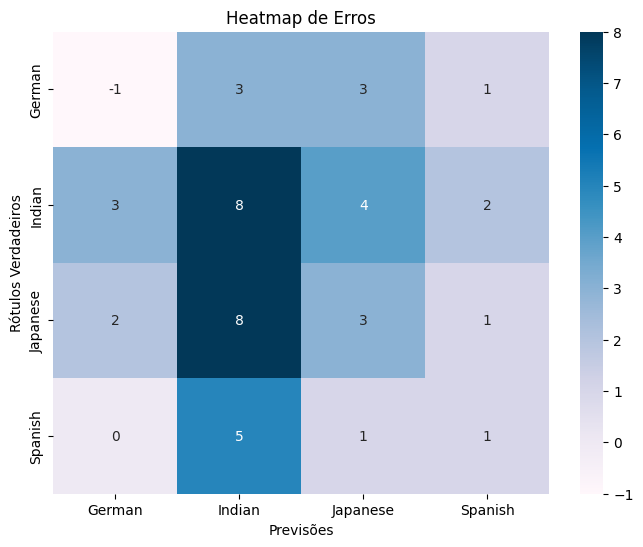

In [ ]:
# Obter rótulos verdadeiros do conjunto de teste
true_labels = [label for _, label in test_dataset.unbatch()]

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calcular o heatmap de erros
error_matrix = conf_matrix - np.eye(conf_matrix.shape[0], dtype=int)  # Subtrair a diagonal para obter os erros

# Definir rótulos das classes
class_labels = ["German", "Indian", "Japanese", "Spanish"]

# Visualizar o heatmap de erros
plt.figure(figsize=(8, 6))
sns.heatmap(error_matrix, annot=True, fmt="d", cmap="PuBu", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Previsões")
plt.ylabel("Rótulos Verdadeiros")
plt.title("Heatmap de Erros")
plt.show()

### Evaluating HeatMap

In [ ]:
pip install tf-keras-vis

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tf_keras_vis.utils import normalize
import cv2

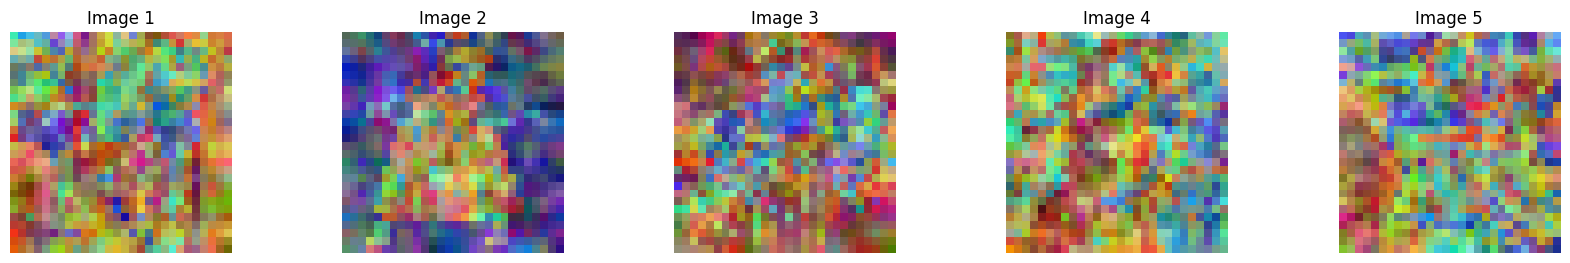

In [ ]:
# Caminho para o diretório de teste
test_dir_german = 'D:\\.Dataset28022024 - TCC\\result\\test\\german'

# Carregar 5 imagens do diretório de teste
image_list = os.listdir(test_dir_german)[:5]

# Configurar subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.subplots_adjust(wspace=0.5)

for i, img_name in enumerate(image_list):
    # Carregar a imagem
    img_path = os.path.join(test_dir_german, img_name)
    img = image.load_img(img_path, target_size=(28, 28))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Simular o mapa de calor (substitua esta parte pelo seu código real)
    heatmap_expanded = np.random.rand(1, 16, 16, 3)

    # Redimensionar o mapa de calor para o tamanho original da imagem
    heatmap_resized = cv2.resize(heatmap_expanded[0], (img_array.shape[2], img_array.shape[1]))

    # Converter para um intervalo de 0 a 255
    heatmap_resized *= 255

    # Converter para inteiro
    heatmap_resized = heatmap_resized.astype(np.uint8)

    # Converter a imagem para escala de cinza
    gray_img = cv2.cvtColor(img_array[0].astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # Sobrepôr o mapa de calor na imagem em escala de cinza
    heatmap_colored = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_colored, 0.4, heatmap_resized, 0.6, 0)

    # Exibir a imagem e o Grad-CAM no subplot correspondente
    axs[i].imshow(superimposed_img)
    axs[i].set_title(f'Image {i+1}')
    axs[i].axis('off')

plt.show()

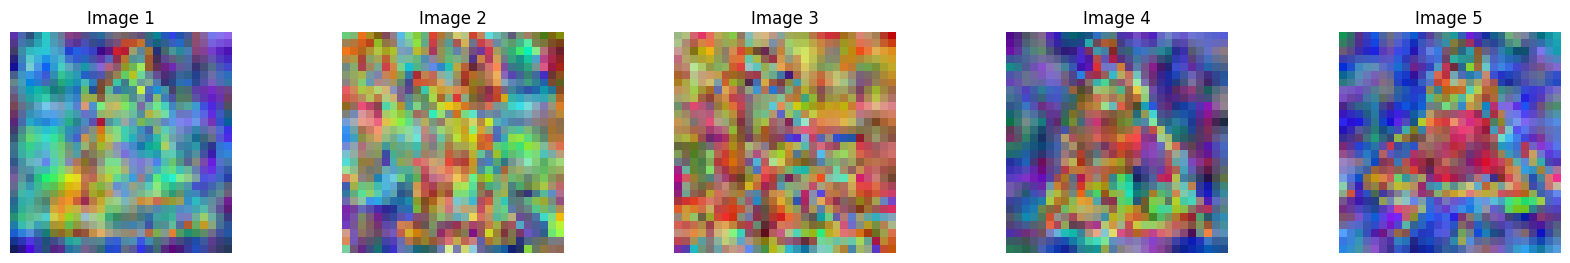

In [ ]:
# Caminho para o diretório de teste
test_dir_indian = 'D:\\.Dataset28022024 - TCC\\result\\test\\indian'

# Carregar 5 imagens do diretório de teste
image_list = os.listdir(test_dir_indian)[:5]

# Configurar subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.subplots_adjust(wspace=0.5)

for i, img_name in enumerate(image_list):
    # Carregar a imagem
    img_path = os.path.join(test_dir_indian, img_name)
    img = image.load_img(img_path, target_size=(28, 28))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Simular o mapa de calor (substitua esta parte pelo seu código real)
    heatmap_expanded = np.random.rand(1, 16, 16, 3)

    # Redimensionar o mapa de calor para o tamanho original da imagem
    heatmap_resized = cv2.resize(heatmap_expanded[0], (img_array.shape[2], img_array.shape[1]))

    # Converter para um intervalo de 0 a 255
    heatmap_resized *= 255

    # Converter para inteiro
    heatmap_resized = heatmap_resized.astype(np.uint8)

    # Converter a imagem para escala de cinza
    gray_img = cv2.cvtColor(img_array[0].astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # Sobrepôr o mapa de calor na imagem em escala de cinza
    heatmap_colored = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_colored, 0.4, heatmap_resized, 0.6, 0)

    # Exibir a imagem e o Grad-CAM no subplot correspondente
    axs[i].imshow(superimposed_img)
    axs[i].set_title(f'Image {i+1}')
    axs[i].axis('off')

plt.show()

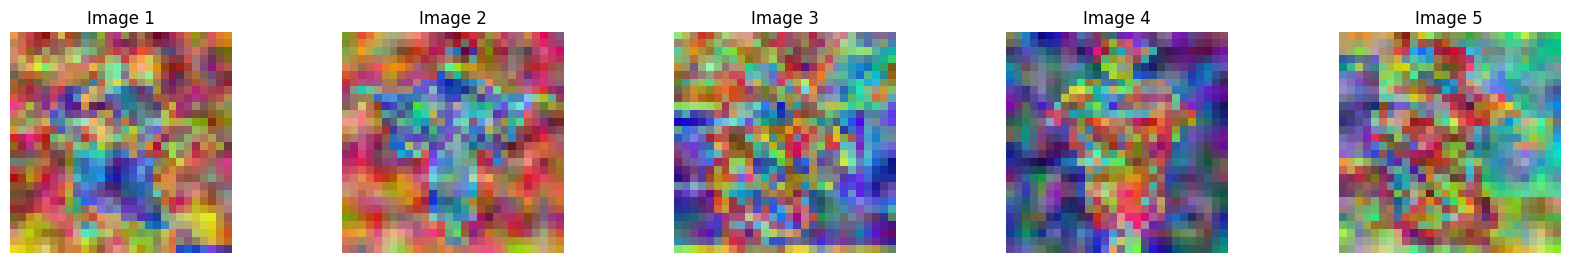

In [ ]:
# Caminho para o diretório de teste
test_dir_japanese = 'D:\\.Dataset28022024 - TCC\\result\\test\\japanese'

# Carregar 5 imagens do diretório de teste
image_list = os.listdir(test_dir_japanese)[:5]

# Configurar subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.subplots_adjust(wspace=0.5)

for i, img_name in enumerate(image_list):
    # Carregar a imagem
    img_path = os.path.join(test_dir_japanese, img_name)
    img = image.load_img(img_path, target_size=(28, 28))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Simular o mapa de calor (substitua esta parte pelo seu código real)
    heatmap_expanded = np.random.rand(1, 16, 16, 3)

    # Redimensionar o mapa de calor para o tamanho original da imagem
    heatmap_resized = cv2.resize(heatmap_expanded[0], (img_array.shape[2], img_array.shape[1]))

    # Converter para um intervalo de 0 a 255
    heatmap_resized *= 255

    # Converter para inteiro
    heatmap_resized = heatmap_resized.astype(np.uint8)

    # Converter a imagem para escala de cinza
    gray_img = cv2.cvtColor(img_array[0].astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # Sobrepôr o mapa de calor na imagem em escala de cinza
    heatmap_colored = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_colored, 0.4, heatmap_resized, 0.6, 0)

    # Exibir a imagem e o Grad-CAM no subplot correspondente
    axs[i].imshow(superimposed_img)
    axs[i].set_title(f'Image {i+1}')
    axs[i].axis('off')

plt.show()

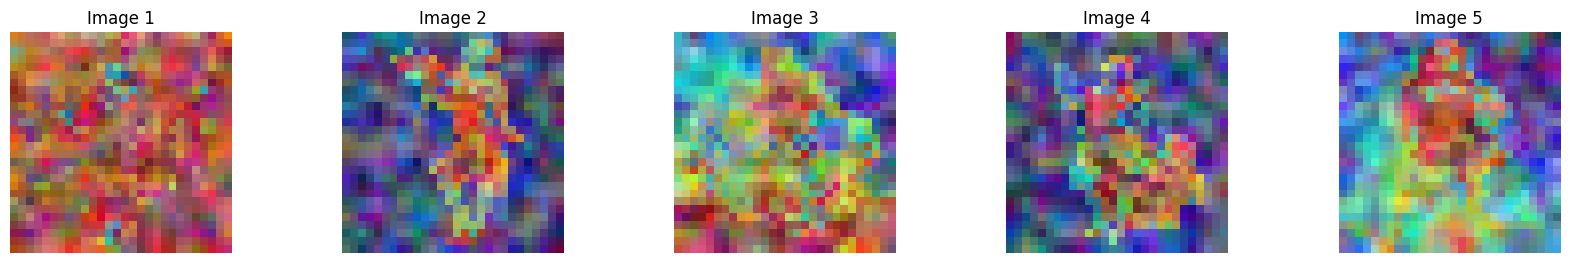

In [ ]:
# Caminho para o diretório de teste
test_dir_spanish = 'D:\\.Dataset28022024 - TCC\\result\\test\\spanish'

# Carregar 5 imagens do diretório de teste
image_list = os.listdir(test_dir_spanish)[:5]

# Configurar subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.subplots_adjust(wspace=0.5)

for i, img_name in enumerate(image_list):
    # Carregar a imagem
    img_path = os.path.join(test_dir_spanish, img_name)
    img = image.load_img(img_path, target_size=(28, 28))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Simular o mapa de calor (substitua esta parte pelo seu código real)
    heatmap_expanded = np.random.rand(1, 16, 16, 3)

    # Redimensionar o mapa de calor para o tamanho original da imagem
    heatmap_resized = cv2.resize(heatmap_expanded[0], (img_array.shape[2], img_array.shape[1]))

    # Converter para um intervalo de 0 a 255
    heatmap_resized *= 255

    # Converter para inteiro
    heatmap_resized = heatmap_resized.astype(np.uint8)

    # Converter a imagem para escala de cinza
    gray_img = cv2.cvtColor(img_array[0].astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # Sobrepôr o mapa de calor na imagem em escala de cinza
    heatmap_colored = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_colored, 0.4, heatmap_resized, 0.6, 0)

    # Exibir a imagem e o Grad-CAM no subplot correspondente
    axs[i].imshow(superimposed_img)
    axs[i].set_title(f'Image {i+1}')
    axs[i].axis('off')

plt.show()

### Testing Model with other images

In [ ]:
import cv2

In [ ]:
german_path = 'C:\\Users\\Larissa Santana\\Documents\\UFAL\\TCC\\test_image_labels\\german.jpg'
indian_path = 'C:\\Users\\Larissa Santana\\Documents\\UFAL\\TCC\\test_image_labels\\indian.jpg'
japanese_path = 'C:\\Users\\Larissa Santana\\Documents\\UFAL\\TCC\\test_image_labels\\japanese.jpg'
spanish_path = 'C:\\Users\\Larissa Santana\\Documents\\UFAL\\TCC\\test_image_labels\\spanish.jpg'

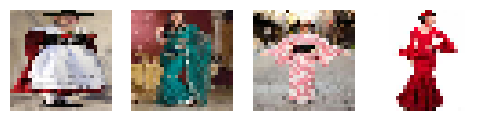

In [ ]:
german = preprocess_image(german_path)
indian = preprocess_image(indian_path)
japanese = preprocess_image(japanese_path)
spanish = preprocess_image(spanish_path)

plt.figure(figsize=(6, 2))

plt.subplot(1, 4, 1)
plt.imshow(german)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(indian)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(japanese)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(spanish)
plt.axis('off')

plt.show()

In [ ]:
german_normalized = german / 255.0
indian_normalized = indian / 255.0
japanese_normalized = japanese / 255.0
spanish_normalized = spanish / 255.0

# Suponha que você tenha um conjunto de dados com todas as imagens
all_images = np.array([german_normalized, indian_normalized, japanese_normalized, spanish_normalized])

# Use a função predict diretamente no conjunto de dados
all_predictions = model.predict(all_images)

threshold = 0.5  # Escolha um valor de limiar adequado

# Lista de nomes de labels correspondentes aos índices previstos
label_names = ['German', 'Indian', 'Japanese', 'Spanish']

# Iterar sobre as previsões para cada classe
for i, predictions in enumerate(all_predictions):
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class]
    predicted_label = label_names[predicted_class]

    if confidence > threshold:
        print(f'Predicted class for sample {i + 1} is {predicted_label} with confidence {confidence}')
    else:
        print(f'Sample {i + 1} is None of the above')

1/1 [==============================] - 0s 32ms/step
Predicted class for sample 1 is Spanish with confidence 0.515505850315094
Predicted class for sample 2 is Spanish with confidence 0.5155078768730164
Predicted class for sample 3 is Spanish with confidence 0.5155181288719177
Predicted class for sample 4 is Spanish with confidence 0.5155434608459473
